In [1]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Download Data

In [2]:
train, test = tf.keras.datasets.mnist.load_data()

In [3]:
type(train), len(train)

(tuple, 2)

In [4]:
train_x, train_y = train
test_x, test_y = test

In [5]:
train_x.shape, train_y.shape

((60000, 28, 28), (60000,))

In [6]:
train_x = np.asarray(train_x, dtype=float)
train_y = np.asarray(train_y, dtype=int)
test_x = np.asarray(test_x, dtype=float)
test_y = np.asarray(test_y, dtype=int)

### Sample data

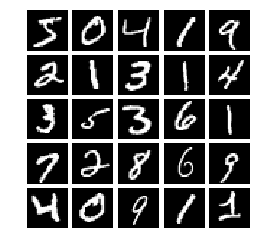

[[5 0 4 1 9]
 [2 1 3 1 4]
 [3 5 3 6 1]
 [7 2 8 6 9]
 [4 0 9 1 1]]


In [7]:
nx, ny = 5, 5
fig, ax = plt.subplots(ny, nx)
fig.subplots_adjust(wspace=-0.7, hspace=0.1)
for i in range(ny):
    for j in range(nx):
        ax[i][j].imshow(train_x[ny*i+j], cmap='gray')
        ax[i][j].axis('off')

plt.show()        
print(np.reshape(train_y[:nx * ny], [nx, ny]))

# Neural Network

![Neural Network](nn.gif)

### Dense Neural Network

In [8]:
def build_dnn(input_size, hidden_layers, output_size):
    x = tf.placeholder(tf.float32, shape=[None, input_size])
    y_ = tf.placeholder(tf.int64, shape=(None,))
    prev_size = input_size
    
    h = x
    for i, layer_size in enumerate(hidden_layers):
        with tf.name_scope("hidden{}".format(i)):
            W = tf.Variable(tf.truncated_normal([prev_size, layer_size]), name="W")
            b = tf.Variable(tf.zeros([layer_size]), name="b")
            
            h = tf.nn.relu(tf.matmul(h, W) + b)
            
        prev_size = layer_size
    
    with tf.name_scope("fc_out"):
        W = tf.Variable(tf.truncated_normal([prev_size, output_size]), name="W")
        b = tf.Variable(tf.zeros([output_size]), name="b")
        
        logits = tf.matmul(h, W) + b
        
    return x, logits, y_

In [17]:
def data_batches(features, labels, batch_size, shuffle=False):
    if shuffle:
        perm = np.random.permutation(len(features))
        features = features[perm]
        labels = labels[perm]
        
    if batch_size is None:
        batch_size = len(features)
    i = 0
    while i < len(features):
        yield features[i:i+batch_size], labels[i:i+batch_size]
        i += batch_size

In [13]:
tf.reset_default_graph()

x, logits, y_ = build_dnn(28*28, [2000, 2000], 10)

loss = tf.losses.sparse_softmax_cross_entropy(labels=y_, logits=logits)
train_op = tf.train.AdamOptimizer(1e-4).minimize(loss)

prediction = tf.argmax(logits, 1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, y_), tf.float32))

In [15]:
sess = tf.Session()
writer = tf.summary.FileWriter("mnist_dnn_raw")

writer.add_graph(sess.graph)


In [18]:


sess.run(tf.global_variables_initializer())
start_time = time.time()
for step in range(2000):
    if (step + 1) % 100 == 0 or step == 0:
        test_accuracy = sess.run(accuracy, feed_dict={x: np.reshape(test_x, [-1, 28*28]), y_: test_y})
        train_loss = sess.run(loss, feed_dict={x: np.reshape(train_x[:300], [-1, 28*28]), y_: train_y[:300]})
        
        writer.add_summary(tf.Summary(value=[tf.Summary.Value(tag="test_accuracy", simple_value=test_accuracy),
                                             tf.Summary.Value(tag="train_loss", simple_value=train_loss)]),
                           step)
        
        dtime = time.time() - start_time
        start_time = time.time()
        print("Step {} ({:.3f}s), loss: {}, test accuracy: {} \t ".format(
                step+1, dtime, train_loss, test_accuracy))
        
    train_data_batches = data_batches(train_x, train_y, batch_size=None, shuffle=True)
    for batch_x, batch_y in train_data_batches:
        sess.run(train_op, feed_dict={x: np.reshape(batch_x[:300], [-1, 28*28]), y_: batch_y[:300]})
        
writer.close()

Step 1 (1.635s), loss: 1894798.125, test accuracy: 0.14880000054836273 	 
Step 100 (43.447s), loss: 323682.53125, test accuracy: 0.5940999984741211 	 
Step 200 (42.659s), loss: 181414.015625, test accuracy: 0.7330999970436096 	 
Step 300 (40.259s), loss: 133026.546875, test accuracy: 0.7910000085830688 	 
Step 400 (39.812s), loss: 104469.0, test accuracy: 0.8263999819755554 	 
Step 500 (40.672s), loss: 84742.4765625, test accuracy: 0.8447999954223633 	 
Step 600 (42.572s), loss: 69700.703125, test accuracy: 0.8593999743461609 	 


KeyboardInterrupt: 

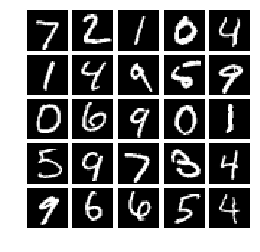

[[7 2 1 0 4]
 [1 4 9 2 9]
 [0 6 9 0 1]
 [8 9 7 8 4]
 [9 6 4 5 4]]


In [19]:
nx, ny = 5, 5
fig, ax = plt.subplots(ny, nx)
fig.subplots_adjust(wspace=-0.7, hspace=0.1)
for i in range(ny):
    for j in range(nx):
        ax[i][j].imshow(test_x[ny*i+j], cmap='gray')
        ax[i][j].axis('off')

plt.show()   

predicted = sess.run(prediction, feed_dict={x: np.reshape(test_x[:nx*ny], [-1, 28*28])})
print(np.reshape(predicted, [nx, ny]))

In [63]:
sess.close()

# Convolution Neural Network

[Convolution Animation](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)

In [15]:
def build_cnn(input_size, channels, fc_layers, output_size):
    x = tf.placeholder(tf.float32, shape=[None, input_size, input_size])
    y_ = tf.placeholder(tf.int64, shape=[None])
    
    with tf.name_scope('reshape'):
        x_image = tf.reshape(x, [-1, input_size, input_size, 1])
    
    prev = x_image
    prev_c = 1
    for i, c in enumerate(channels):
        with tf.name_scope('conv{}'.format(i)):
            W_conv = tf.Variable(tf.truncated_normal([3, 3, prev_c, c]))
            h_conv = tf.nn.relu(tf.nn.conv2d(prev, W_conv, strides=[1, 1, 1, 1], padding='SAME'))
        
        with tf.name_scope('pool{}'.format(i)):
            h_pool = tf.nn.max_pool(h_conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
            
        prev = h_pool
        prev_c = c
    
    h = tf.contrib.layers.flatten(h_pool)
    prev_size = h.get_shape().as_list()[1]
    for i, layer_size in enumerate(fc_layers):
        with tf.name_scope("fc{}".format(i)):
            W = tf.Variable(tf.truncated_normal([prev_size, layer_size]), name="W")
            b = tf.Variable(tf.zeros([layer_size]), name="b")
            
            h = tf.nn.relu(tf.matmul(h, W) + b)
            
        prev_size = layer_size
        
    with tf.name_scope("fc_out"):
        W = tf.Variable(tf.truncated_normal([prev_size, output_size]), name="W")
        b = tf.Variable(tf.zeros([output_size]), name="b")
        
        logits = tf.matmul(h, W) + b
        
    return x, logits, y_

In [16]:
tf.reset_default_graph()

x, logits, y_ = build_cnn(28, [32, 64], [1000], 10)

loss = tf.losses.sparse_softmax_cross_entropy(labels=y_, logits=logits)
train_op = tf.train.AdamOptimizer(1e-4).minimize(loss)

prediction = tf.argmax(logits, 1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, y_), tf.float32))

In [18]:
sess = tf.Session()
writer = tf.summary.FileWriter("mnist_cnn_raw")

writer.add_graph(sess.graph)

sess.run(tf.global_variables_initializer())

start_time = time.time()
for step in range(300):
    if (step + 1) % 100 == 0 or step == 0:
        test_accuracy = sess.run(accuracy, feed_dict={x: test_x, y_: test_y})
        sample = np.random.choice(len(train_x), 1000, replace=False)
        train_loss = sess.run(loss, feed_dict={x: train_x[sample], y_: train_y[sample]})
        
        writer.add_summary(tf.Summary(value=[tf.Summary.Value(tag="test_accuracy", simple_value=test_accuracy),
                                             tf.Summary.Value(tag="train_loss", simple_value=train_loss)]),
                           step)
        
        dtime = time.time() - start_time
        start_time = time.time()
        print("Step {} ({:.3f}s), loss: {}, test accuracy: {} \t ".format(
                step+1, dtime, train_loss, test_accuracy))
        
    train_data_batches = data_batches(train_x, train_y, batch_size=128, shuffle=True)
    for batch_x, batch_y in train_data_batches:
        sess.run(train_op, feed_dict={x: batch_x, y_: batch_y})
        
writer.close()

Step 1 (0.105s), loss: 4266859.5, test accuracy: 0.08940000087022781 	 
Step 100 (265.081s), loss: 13.829000473022461, test accuracy: 0.9775000214576721 	 
Step 200 (262.959s), loss: 0.0, test accuracy: 0.9817000031471252 	 
Step 300 (215.776s), loss: 0.0, test accuracy: 0.9817000031471252 	 


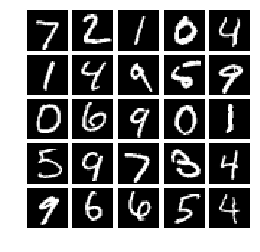

[[7 2 1 0 4]
 [1 4 9 5 9]
 [0 6 9 0 1]
 [5 9 7 8 4]
 [9 6 6 5 4]]


In [21]:
nx, ny = 5, 5
fig, ax = plt.subplots(ny, nx)
fig.subplots_adjust(wspace=-0.7, hspace=0.1)
for i in range(ny):
    for j in range(nx):
        ax[i][j].imshow(test_x[ny*i+j], cmap='gray')
        ax[i][j].axis('off')

plt.show()   

predicted = sess.run(prediction, feed_dict={x: test_x[:nx*ny]})
print(np.reshape(predicted, [nx, ny]))

In [11]:
sess.close()

### Dense Neural Network with `Estimator`

In [20]:
feature_columns = [tf.feature_column.numeric_column(key='x', shape=(28, 28))]

In [21]:
mnist_dnn_classifier = tf.estimator.DNNClassifier(
                        feature_columns=feature_columns,
                        hidden_units=[2000, 200],
                        n_classes=10,
                        model_dir="mnist_dnn_estimator")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'mnist_dnn_estimator', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1373dbf60>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [22]:
def train_input_fn(features:dict, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)
    return dataset.make_one_shot_iterator().get_next()

In [23]:
def eval_input_fn(features:dict, labels, batch_size):
    if labels is None:
        return tf.data.Dataset.from_tensor_slices(features).batch(batch_size)
    
    return tf.data.Dataset.from_tensor_slices((features, labels)).batch(batch_size)

In [24]:
mnist_dnn_classifier.train(input_fn=lambda: train_input_fn({"x": train_x}, train_y, 64), steps=500)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from mnist_dnn_estimator/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2001 into mnist_dnn_estimator/model.ckpt.
INFO:tensorflow:loss = 15.752353, step = 2001
INFO:tensorflow:global_step/sec: 11.4869
INFO:tensorflow:loss = 20.943468, step = 2101 (8.702 sec)
INFO:tensorflow:global_step/sec: 92.3036
INFO:tensorflow:loss = 13.359367, step = 2201 (1.082 sec)
INFO:tensorflow:global_step/sec: 93.994
INFO:tensorflow:loss = 31.687553, step = 2301 (1.064 sec)
INFO:tensorflow:global_step/sec: 80.8965
INFO:tensorflow:loss = 7.642435, step = 2401 (1.236 sec)
INFO:tensorflow:Saving checkpoints for 2500 into mnist_dnn_estimator/model.ckpt.
INFO:tensorflow:Loss for final step: 21.072796.


In [30]:
eval_results = mnist_classifier.evaluate(input_fn=lambda: eval_input_fn({"x": test_x}, test_y, batch_size=64))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-23-07:25:29
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from mnist_convnet_model/model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-23-07:25:32
INFO:tensorflow:Saving dict for global step 8000: accuracy = 0.9874, global_step = 8000, loss = 0.037221294


In [31]:
print(eval_results)

{'accuracy': 0.9874, 'loss': 0.037221294, 'global_step': 8000}


In [37]:
predicted = mnist_dnn_classifier.predict(input_fn=lambda: eval_input_fn({"x": test_x[:nx*ny]}, test_y[:nx*ny], 64))

In [38]:
predicted_ids = [p['class_ids'][0] for p in predicted]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from mnist_dnn_estimator/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


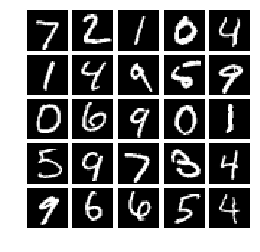

[[7 2 1 0 4]
 [1 4 9 6 9]
 [0 6 9 0 1]
 [5 9 7 8 4]
 [9 6 6 5 4]]


In [40]:
nx, ny = 5, 5
fig, ax = plt.subplots(ny, nx)
fig.subplots_adjust(wspace=-0.7, hspace=0.1)
for i in range(ny):
    for j in range(nx):
        ax[i][j].imshow(test_x[ny*i+j], cmap='gray')
        ax[i][j].axis('off')

plt.show()   

print(np.reshape(predicted_ids, [nx, ny]))

### CNN model with custom `Estimator`

In [27]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features['x'], [-1, 28, 28, 1])
    
    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
                inputs=input_layer,
                filters=32,
                kernel_size=[5, 5],
                padding="same",
                activation=tf.nn.relu)
    
    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
                inputs=pool1,
                filters=64,
                kernel_size=[5, 5],
                padding="same",
                activation=tf.nn.relu)
    
    # Pooling Layer #2
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
                inputs=dense, rate=0.4, training=(mode == tf.estimator.ModeKeys.TRAIN))
    
    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)
    
    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT  and by the `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # `sparse_softmax_cross_entropy` takes class number as label
    # `softmax_cross_entropy` takes onehot vector as label
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
                    loss=loss,
                    global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
                        labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
                mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [28]:
mnist_classifier = tf.estimator.Estimator(
                        model_fn=cnn_model_fn, model_dir="mnist_convnet_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'mnist_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbfec70f588>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [29]:
mnist_classifier.train(
    input_fn=lambda: train_input_fn({"x": train_x}, train_y, batch_size=64),
    steps=2000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from mnist_convnet_model/model.ckpt-6000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 6001 into mnist_convnet_model/model.ckpt.
INFO:tensorflow:loss = 0.01898283138871193, step = 6000
INFO:tensorflow:global_step/sec: 26.7322
INFO:tensorflow:loss = 0.10859496891498566, step = 6100 (3.553 sec)
INFO:tensorflow:global_step/sec: 25.2511
INFO:tensorflow:loss = 0.12122948467731476, step = 6200 (3.958 sec)
INFO:tensorflow:global_step/sec: 29.0859
INFO:tensorflow:loss = 0.024764500558376312, step = 6300 (3.438 sec)
INFO:tensorflow:global_step/sec: 29.1064
INFO:tensorflow:loss = 0.019666021689772606, step = 6400 (3.435 sec)
INFO:tensorflow:global_step/sec: 29.1244
INFO:tensorflow:loss = 0.05532953143119812, step = 6500 (3.434 sec)
I

In [30]:
eval_results = mnist_classifier.evaluate(input_fn=lambda: eval_input_fn({"x": test_x}, test_y, batch_size=64))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-23-07:25:29
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from mnist_convnet_model/model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-23-07:25:32
INFO:tensorflow:Saving dict for global step 8000: accuracy = 0.9874, global_step = 8000, loss = 0.037221294


In [31]:
print(eval_results)

{'accuracy': 0.9874, 'loss': 0.037221294, 'global_step': 8000}
